# Image Classification Project 6
Choose three classes from the Open Images Dataset. Train a neural net that is able to classify images into these three categories.



In [13]:
classes = ['Cat', 'Dog', 'Person']
print(classes)

['Cat', 'Dog', 'Person']


## Dataset
https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection

## Base model
VGG 19

In [27]:
# imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from openimages import download
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Conv2D, LeakyReLU
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import keras
from keras.utils import to_categorical


In [3]:
# Path to the directory where the images are stored
base_dir = './dataset'

# Check if the directory exists
if os.path.exists(base_dir):
    # Delete the directory and its contents
    shutil.rmtree(base_dir)

# number of images per class
n_images = 10

# Download images for each class using Open Images
download.download_dataset(
    dest_dir=base_dir,
    class_labels=classes,
    limit=n_images
)

2023-06-09  15:41:51 INFO Downloading 10 train images for class 'cat'
100%|██████████| 10/10 [00:01<00:00,  6.39it/s]
2023-06-09  15:41:54 INFO Downloading 10 train images for class 'dog'
100%|██████████| 10/10 [00:01<00:00,  5.18it/s]
2023-06-09  15:41:57 INFO Downloading 10 train images for class 'person'
100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


{'cat': {'images_dir': './dataset\\cat\\images'},
 'dog': {'images_dir': './dataset\\dog\\images'},
 'person': {'images_dir': './dataset\\person\\images'}}

## Task
1. Preparation: Split dataset into a 70/30 Train/test split


In [103]:
# Define the image directory
image_dir = 'dataset'

# Initialize lists to store images and labels
images = []
labels = []

# Iterate over subdirectories
for class_name in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_name)

    if os.path.isdir(class_dir):
        # Iterate over the image files in the subdirectory
        class_dir = os.path.join(class_dir, "images")
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(class_dir, filename)
                # Check if the image is RGB
                with Image.open(image_path) as image:
                    if image.mode == "RGB":
                        # Resize the image to the desired dimensions
                        image = image.resize((224, 224))
                        # Convert the image to numpy array
                        image_array = np.array(image)
                        # Append the image to the list
                        images.append(image_array)
                        # Assign the label based on the subdirectory (class name)
                        label = class_name
                        labels.append(label)

# Convert the image list to a numpy array
images = np.array(images)
# Convert the labels list to a numpy array
labels = np.array(labels)

In [104]:
# Get the length of the images array
length = images.shape[0]

# Shuffle the images and labels in unison
random_indices = np.random.permutation(length)
images = images[random_indices]
labels = labels[random_indices]

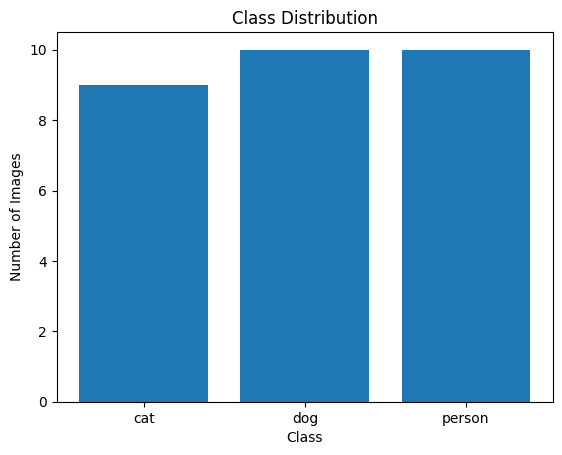

In [105]:
# Count the number of images in each class
unique_classes, class_counts = np.unique(labels, return_counts=True)
# Plot the class distribution
plt.bar(unique_classes, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

In [115]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
# Create a LabelEncoder object
label_encoder = LabelEncoder()
# Fit the label encoder on the labels
label_encoder.fit(labels)
# Transform the labels to encoded integers
encoded_labels = label_encoder.transform(labels)
# Convert the encoded labels to one-hot encoded vectors
one_hot_labels = to_categorical(encoded_labels, num_classes=3)
# Split the data into training and testing subsets
train_images, test_images, train_labels, test_labels = train_test_split(images, one_hot_labels, test_size=0.3, random_state=42)


# Print the shapes of the training and testing subsets
print("Train Images shape:", train_images.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Images shape:", test_images.shape)
print("Test Labels shape:", test_labels.shape)

Train Images shape: (20, 224, 224, 3)
Train Labels shape: (20, 3)
Test Images shape: (9, 224, 224, 3)
Test Labels shape: (9, 3)


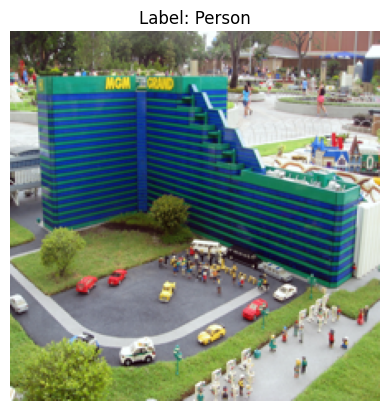

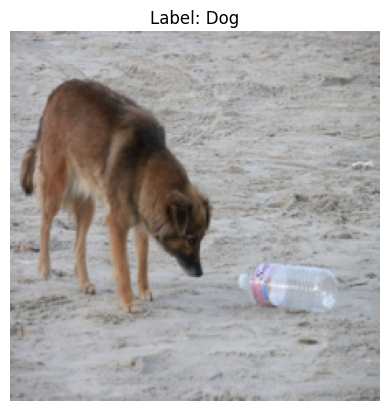

In [116]:
# Define the class labels
class_labels = ['Cat', 'Dog', 'Person']
# Show the first two images
for i in range(2):
    image = train_images[i]
    label = train_labels[i]
    # Convert one-hot encoded label to class index
    class_index = label.argmax()
    # Get the class label corresponding to the index
    class_label = class_labels[class_index]
    # Display the image and label
    plt.imshow(image)
    plt.title(f"Label: {class_label}")
    plt.axis('off')
    plt.show()

2. Train a VGG19 network from scratch (randomly initialized weights) and estimate the testset accuracy.

In [117]:
# define image height and with
img_height = 224
img_width = 224
epochs = 10
batch_size = 32

In [112]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
# Create a new model
plain_model = Sequential()
# Add the base model as the first layer
plain_model.add(base_model)
# Flatten the output of the base model
plain_model.add(Flatten())
# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))
# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
plain_model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)

# Save the model
plain_model.save("models/plain_model_raw_data.h5")

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 1.1017 - accuracy: 0.3500
Epoch 2/10
1/1 [==============================] - 9s 9s/step - loss: 992.6756 - accuracy: 0.3500
Epoch 3/10


KeyboardInterrupt: 

3. Use an imagenet pretrained VGG19 network, train the model and estimate the testset accuracy.

In [14]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()
# Add the base model as the first layer
trained_model.add(pre_trained_model)
# Flatten the output of the base model
trained_model.add(Flatten())
# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("models/trained_model_raw_data.h5")

Epoch 1/10
59/99 [================>.............] - ETA: 3:04 - loss: 2.3131 - accuracy: 0.3283

KeyboardInterrupt: 

#### The differences in loss and accuracy of the plain and pre trained network over the first 10 epochs

In [ ]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

4. Data cleansing: Remove “bad” images from the dataset. Which did you remove? How many? Discuss results.

5. Add data augmentation: 
    - Random flip
    - Random contrast
    - Random translation

In [ ]:
def custom_preprocessing(image):
    # Generate a random contrast factor
    contrast_factor = np.random.uniform(0.8, 1.2)
    # Apply contrast adjustment
    image = image * contrast_factor
    image = tf.clip_by_value(image, 0.0, 1.0)  # Clip values to the [0, 1] range
    return image

In [ ]:
# Define parameters for the loader
batch_size = 10
img_height = 224
img_width = 224

# Load the training data
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.3,
        horizontal_flip=True,  # Apply random flip
        vertical_flip=True,  # Apply random flip
        width_shift_range=0.2,  # Apply random translation
        height_shift_range=0.2,  # Apply random translation
        preprocessing_function=custom_preprocessing # Apply random contrast
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # set as training data

# Load the validation data
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # set as validation data

#### Train both models again

In [ ]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
plain_model = Sequential()
# Add the base model as the first layer
plain_model.add(base_model)
# Flatten the output of the base model
plain_model.add(Flatten())
# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
plain_history = plain_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

plain_model.save("plain_model_augmentated_data.h5")

In [ ]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()
# Add the base model as the first layer
trained_model.add(pre_trained_model)
# Flatten the output of the base model
trained_model.add(Flatten())
# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("trained_model_augmentated_data.h5")

In [ ]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6. Rebuild VGG19. After layer block4_conv4 (25, 25, 512):
    - Add inception layer with dimensionality reduction (no of output filters should be 512, choose own values for the filter dimensionality reduction in 1x1 layers)
    - Add conv layer (kernel 1x1,  filters 1024, padding valid, stride 1, activation leaky relu)
    - Add conv layer (kernel 3x3,  filters 1024, padding same, stride 1, activation relu)
    - Freeze conv2 layers and before

In [ ]:
# Load a VGG19 model with random initialized weights
base_model = VGG19(weights=None, include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
plain_model = Sequential()

# Add layers until block4_conv4
for layer in base_model.layers:
    plain_model.add(layer)
    if layer.name == 'block4_conv4':
        break

# Freeze the layers before block2_conv2
freeze = True
for layer in plain_model.layers:
    if layer.name == 'block2_conv2':
        freeze = False
    layer.trainable = not freeze

# Add the inception layer with dimensionality reduction
plain_model.add(Conv2D(512, (1, 1), activation='relu'))
plain_model.add(Conv2D(256, (1, 1), activation='relu'))
plain_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Add the conv layer with kernel 1x1, filters 1024, padding valid, stride 1, activation leaky relu
plain_model.add(Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1)))

# Add the conv layer with kernel 3x3, filters 1024, padding same, stride 1, activation relu
plain_model.add(Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu'))

# Flatten the output of the last added layer
plain_model.add(Flatten())

# Add the final output layer with softmax activation
plain_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
plain_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
plain_history = plain_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

plain_model.save("plain_Rebuild_VGG19_model_augmentated_data.h5")

In [ ]:
# Load a VGG19 model with random initialized weights
pre_trained_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Create a new model
trained_model = Sequential()

# Add layers until block4_conv4
for layer in pre_trained_model.layers:
    trained_model.add(layer)
    if layer.name == 'block4_conv4':
        break

# Freeze the layers before block2_conv2
freeze = True
for layer in trained_model.layers:
    if layer.name == 'block2_conv2':
        freeze = False
    layer.trainable = not freeze

# Add the inception layer with dimensionality reduction
trained_model.add(Conv2D(512, (1, 1), activation='relu'))
trained_model.add(Conv2D(256, (1, 1), activation='relu'))
trained_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))

# Add the conv layer with kernel 1x1, filters 1024, padding valid, stride 1, activation leaky relu
trained_model.add(Conv2D(1024, (1, 1), padding='valid', strides=1, activation=LeakyReLU(alpha=0.1)))

# Add the conv layer with kernel 3x3, filters 1024, padding same, stride 1, activation relu
trained_model.add(Conv2D(1024, (3, 3), padding='same', strides=1, activation='relu'))

# Flatten the output of the last added layer
trained_model.add(Flatten())

# Add the final output layer with softmax activation
trained_model.add(Dense(len(classes), activation='softmax'))

# Compile the model
trained_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
trained_history  = trained_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10)

trained_model.save("trained_Rebuild_VGG19_model_augmentated_data.h5")

In [ ]:
# Extract loss and accuracy values for both models
plain_loss = plain_history.history['loss']
plain_accuracy = plain_history.history['accuracy']
trained_loss = trained_history.history['loss']
trained_accuracy = trained_history.history['accuracy']

# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_loss, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_loss, 'r-', label='Pre-trained Model')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), plain_accuracy, 'b-', label='Plain Model')
plt.plot(range(1, 11), trained_accuracy, 'r-', label='Pre-trained Model')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7. Test a few of your own images and present the results

8. Answer the following questions:
    - What accuracy can be achieved? What is the accuracy of the train vs. test set?
    - On what infrastructure did you train it? What is the inference time?
    - What are the number of parameters of the model?
    - Which categories are most likely to be confused by the algorithm? Show results in a confusion matrix.